In [1]:
library(data.table)
library(dplyr)
library(Matrix)
library(BuenColors)
library(stringr)
library(cowplot)
library(SummarizedExperiment)
library(chromVAR)
library(BSgenome.Hsapiens.UCSC.hg19)
library(JASPAR2016)
library(motifmatchr)
library(GenomicRanges)
library(irlba)
library(cicero)
library(umap)
library(cisTopic)
library(prabclus)
library(BrockmanR)
library(jackstraw)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:data.table’:

    between, first, last

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: MASS

Attaching package: ‘MASS’

The following object is masked from ‘package:dplyr’:

    select

Loading required package: ggplot2

Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave

Loading required package: GenomicRanges
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘

#### define functions

In [2]:
read_FM <- function(filename){
    df_FM = data.frame(readRDS(filename),stringsAsFactors=FALSE,check.names=FALSE)
    rownames(df_FM) <- make.names(rownames(df_FM), unique=TRUE)
    df_FM[is.na(df_FM)] <- 0
    return(df_FM)
}

run_pca <- function(mat,num_pcs=50,remove_first_PC=FALSE,scale=FALSE,center=FALSE){
    set.seed(2019) 
    mat = as.matrix(mat)
    SVD = irlba(mat, num_pcs, num_pcs,scale=scale,center=center)
    sk_diag = matrix(0, nrow=num_pcs, ncol=num_pcs)
    diag(sk_diag) = SVD$d
    if(remove_first_PC){
        sk_diag[1,1] = 0
        SVD_vd = (sk_diag %*% t(SVD$v))[2:num_pcs,]
    }else{
        SVD_vd = sk_diag %*% t(SVD$v)
    }
    return(SVD_vd)
}

elbow_plot <- function(mat,num_pcs=50,scale=FALSE,center=FALSE,title='',width=3,height=3){
    set.seed(2019) 
    mat = data.matrix(mat)
    SVD = irlba(mat, num_pcs, num_pcs,scale=scale,center=center)
    options(repr.plot.width=width, repr.plot.height=height)
    df_plot = data.frame(PC=1:num_pcs, SD=SVD$d);
#     print(SVD$d[1:num_pcs])
    p <- ggplot(df_plot, aes(x = PC, y = SD)) +
      geom_point(col="#cd5c5c",size = 1) + 
      ggtitle(title)
    return(p)
}

run_umap <- function(fm_mat){
    umap_object = umap(t(fm_mat),random_state = 2019)
    df_umap = umap_object$layout
    return(df_umap)
}


plot_umap <- function(df_umap,labels,title='UMAP',colormap=colormap){
    set.seed(2019) 
    df_umap = data.frame(cbind(df_umap,labels),stringsAsFactors = FALSE)
    colnames(df_umap) = c('umap_1','umap_2','celltype')
    df_umap$umap_1 = as.numeric(df_umap$umap_1)
    df_umap$umap_2 = as.numeric(df_umap$umap_2)
    options(repr.plot.width=4, repr.plot.height=4)
    p <- ggplot(shuf(df_umap), aes(x = umap_1, y = umap_2, color = celltype)) +
      geom_point(size = 1) + scale_color_manual(values = colormap) +
      ggtitle(title)
    return(p)
}

### Input

In [3]:
workdir = './output/'

path_umap = paste0(workdir,'umap_rds/')
system(paste0('mkdir -p ',path_umap))

path_fm = paste0(workdir,'feature_matrices/')

In [4]:
metadata <- read.table('./input/metadata.tsv',
                         header = TRUE,
                         stringsAsFactors=FALSE,quote="",row.names=1)

In [5]:
list.files(path_fm,pattern="^FM*")

[1] "FM_ChromVAR_buenrostro2018bulkpeaks_kmers.rds" 
[2] "FM_ChromVAR_buenrostro2018bulkpeaks_motifs.rds"
[3] "FM_Cicero_buenrostro2018bulkpeaks.rds"         
[4] "FM_cisTopic_buenrostro2018bulkpeaks.rds"       
[5] "FM_Control_buenrostro2018bulkpeaks.rds"        
[6] "FM_Cusanovich2018_buenrostro2018bulkpeaks.rds" 
[7] "FM_GeneScoring_buenrostro2018bulkpeaks.rds"    
[8] "FM_scABC_buenrostro2018bulkpeaks.rds"          
[9] "FM_Scasat_buenrostro2018bulkpeaks.rds"

In [6]:
# read in feature matrices and double check if cell names of feature matrices are consistent with metadata
flag_identical = c()
for (filename in list.files(path_fm,pattern="^FM*")){
    filename_split = unlist(strsplit(sub('\\.rds$', '', filename),'_'))
    method_i = filename_split[2]
    if(method_i == 'chromVAR'){
        method_i = paste(filename_split[2],filename_split[4],sep='_')
    }
    print(paste0('Read in ','fm_',method_i))
    assign(paste0('fm_',method_i),read_FM(paste0(path_fm,filename)))
    #check if column names are the same
    flag_identical[[method_i]] = identical(colnames(eval(as.name(paste0('fm_',method_i)))),
                                            rownames(metadata))
}

[1] "Read in fm_ChromVAR_kmers"
[1] "Read in fm_ChromVAR_motifs"
[1] "Read in fm_Cicero"
[1] "Read in fm_cisTopic"
[1] "Read in fm_Control"
[1] "Read in fm_Cusanovich2018"
[1] "Read in fm_GeneScoring"
[1] "Read in fm_scABC"
[1] "Read in fm_Scasat"


In [7]:
flag_identical

ChromVAR_kmers ChromVAR_motifs          Cicero        cisTopic         Control 
           TRUE            TRUE            TRUE            TRUE            TRUE 
 Cusanovich2018     GeneScoring           scABC          Scasat 
           TRUE            TRUE            TRUE            TRUE

In [8]:
all(flag_identical)

[1] TRUE

In [9]:
labels = metadata$label
colormap = c(jdb_color_maps, "UNK" = "#333333" )

#### Control

In [10]:
df_umap_Control <- run_umap(fm_Control)

In [11]:
dim(fm_Control)

[1]   50 2034

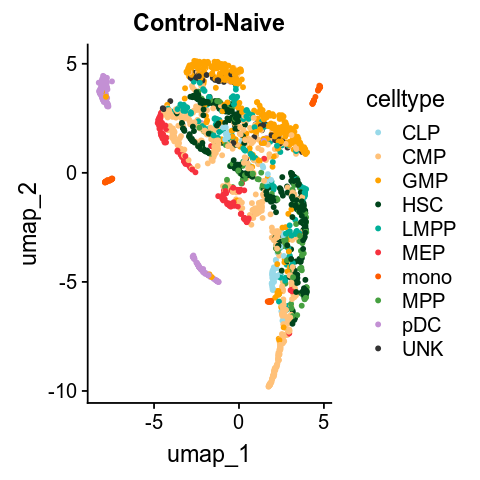

In [12]:
p_Control <- plot_umap(df_umap_Control,labels = labels,colormap = colormap,title='Control-Naive')
p_Control

#### chromVAR

In [13]:
df_umap_chromVAR_motifs <- run_umap(fm_chromVAR_motifs)
df_umap_chromVAR_kmers <- run_umap(fm_chromVAR_kmers)

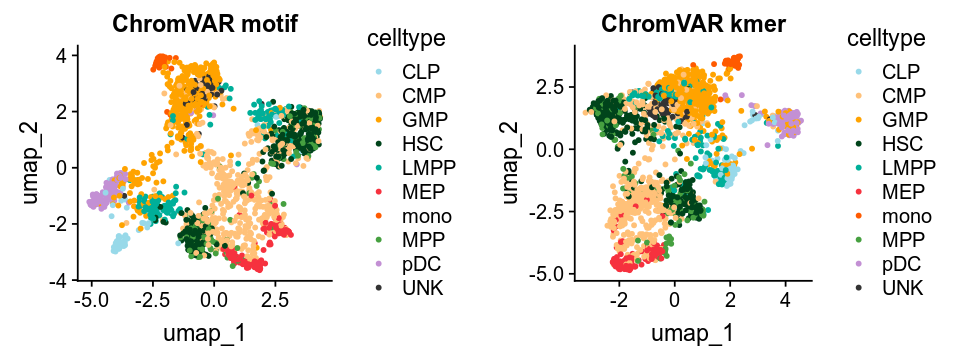

In [14]:
p_chromVAR_motifs <- plot_umap(df_umap_chromVAR_motifs,labels = labels,colormap = colormap,title='chromVAR motif')
p_chromVAR_kmers <- plot_umap(df_umap_chromVAR_kmers,labels = labels,colormap = colormap,title='chromVAR kmer')

options(repr.plot.width=8, repr.plot.height=3)
cowplot::plot_grid(p_chromVAR_motifs,p_chromVAR_kmers)

Warning message in irlba(mat, num_pcs, num_pcs, scale = scale, center = center):
"You're computing too large a percentage of total singular values, use a standard svd instead."

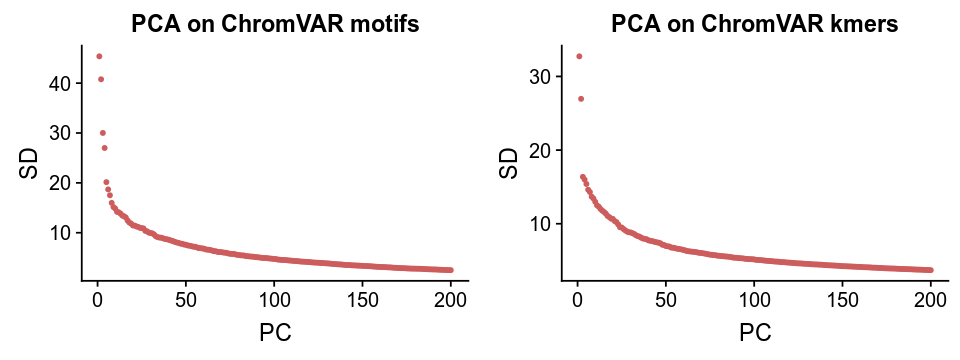

In [15]:
p_elbow_chromVAR_motifs <- elbow_plot(fm_chromVAR_motifs,num_pcs = 200, title = 'PCA on chromVAR motifs')
p_elbow_chromVAR_kmers <- elbow_plot(fm_chromVAR_kmers,num_pcs = 200, title = 'PCA on chromVAR kmers')

options(repr.plot.width=8, repr.plot.height=3)
cowplot::plot_grid(p_elbow_chromVAR_motifs,p_elbow_chromVAR_kmers)

In [16]:
fm_chromVAR_motifs2 = run_pca(fm_chromVAR_motifs,num_pcs = 100)
fm_chromVAR_kmers2 = run_pca(fm_chromVAR_kmers,num_pcs = 100)

In [17]:
df_umap_chromVAR_motifs2 <- run_umap(fm_chromVAR_motifs2)
df_umap_chromVAR_kmers2 <- run_umap(fm_chromVAR_kmers2)

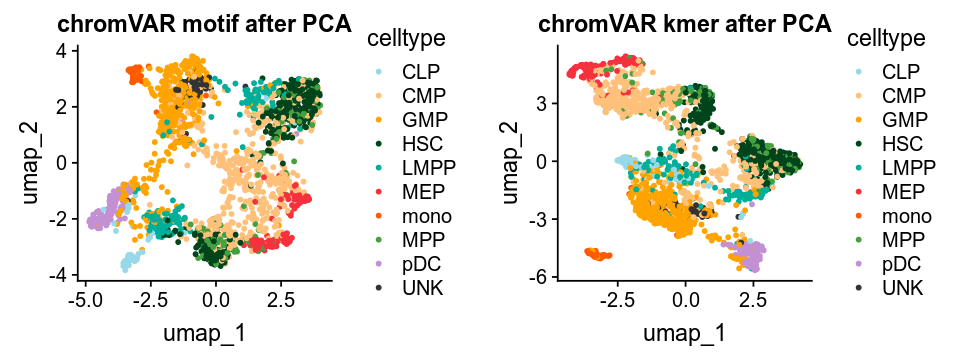

In [18]:
p_chromVAR_motifs2 <- plot_umap(df_umap_chromVAR_motifs2,labels = labels,colormap = colormap,title='chromVAR motif after PCA')
p_chromVAR_kmers2 <- plot_umap(df_umap_chromVAR_kmers2,labels = labels,colormap = colormap,title='chromVAR kmer after PCA')

options(repr.plot.width=8, repr.plot.height=3)
cowplot::plot_grid(p_chromVAR_motifs2,p_chromVAR_kmers2)

### Cusanovich2018

In [19]:
df_umap_Cusanovich2018 <- run_umap(fm_Cusanovich2018)

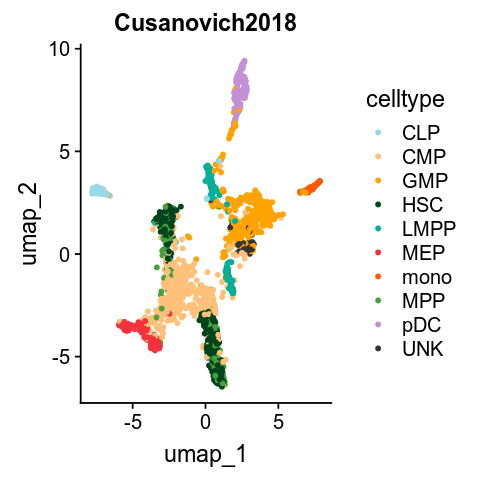

In [20]:
p_Cusanovich2018 <- plot_umap(df_umap_Cusanovich2018,labels = labels,colormap = colormap,title='Cusanovich2018')
p_Cusanovich2018

### cisTopic

In [21]:
df_umap_cisTopic <- run_umap(fm_cisTopic)

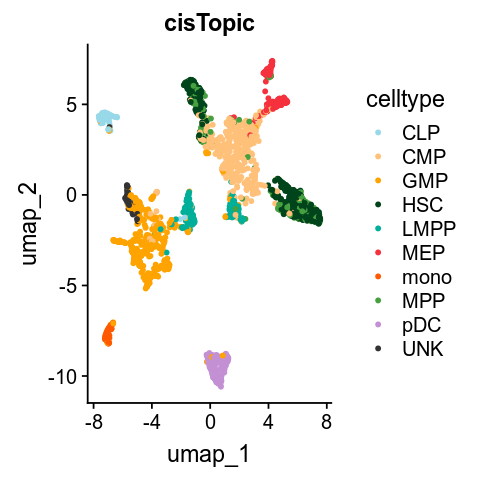

In [22]:
p_cisTopic <- plot_umap(df_umap_cisTopic,labels = labels,colormap = colormap,title='cisTopic')
p_cisTopic

### Gene Scoring

In [23]:
df_umap_GeneScoring <- run_umap(fm_GeneScoring)

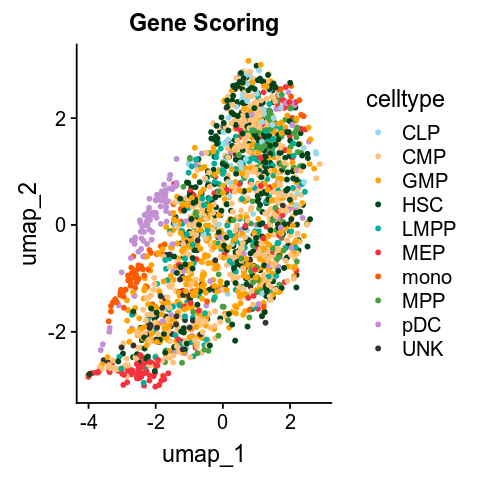

In [24]:
p_GeneScoring <- plot_umap(df_umap_GeneScoring,labels = labels,colormap = colormap,title='Gene Scoring')
p_GeneScoring

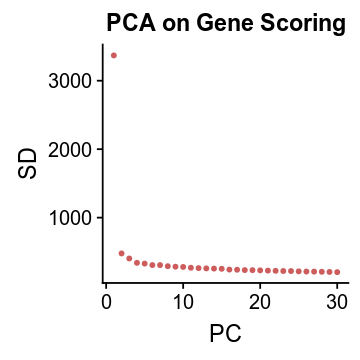

In [25]:
p_elbow_GeneScoring <- elbow_plot(fm_GeneScoring,num_pcs = 30, title = 'PCA on Gene Scoring')
p_elbow_GeneScoring

In [26]:
fm_GeneScoring2 = run_pca(fm_GeneScoring,num_pcs = 10)

In [27]:
df_umap_GeneScoring2 <- run_umap(fm_GeneScoring2)

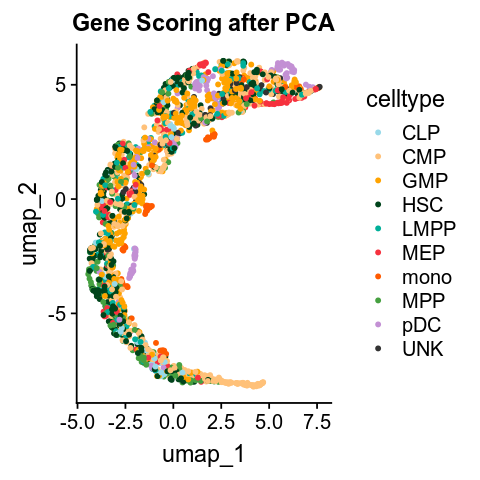

In [28]:
p_GeneScoring2 <- plot_umap(df_umap_GeneScoring2,labels = labels,colormap = colormap,title='Gene Scoring after PCA')
p_GeneScoring2

### Cicero

In [29]:
df_umap_Cicero <- run_umap(fm_Cicero)

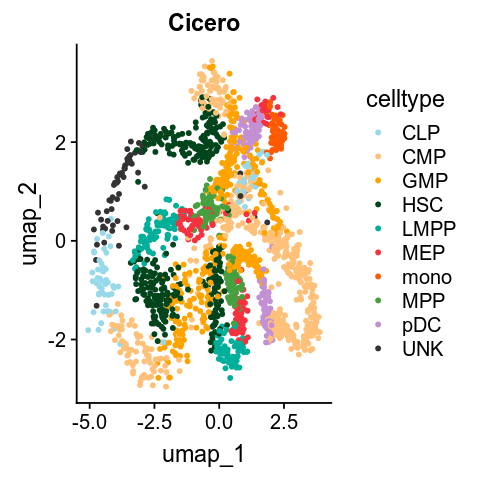

In [30]:
p_Cicero <- plot_umap(df_umap_Cicero,labels = labels,colormap = colormap,title='Cicero')
p_Cicero

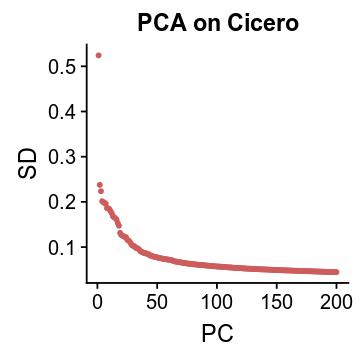

In [31]:
p_elbow_Cicero <- elbow_plot(fm_Cicero,num_pcs = 200, title = 'PCA on Cicero')
p_elbow_Cicero

In [32]:
fm_Cicero2 = run_pca(fm_Cicero,num_pcs = 100)

In [33]:
df_umap_Cicero2 <- run_umap(fm_Cicero2)

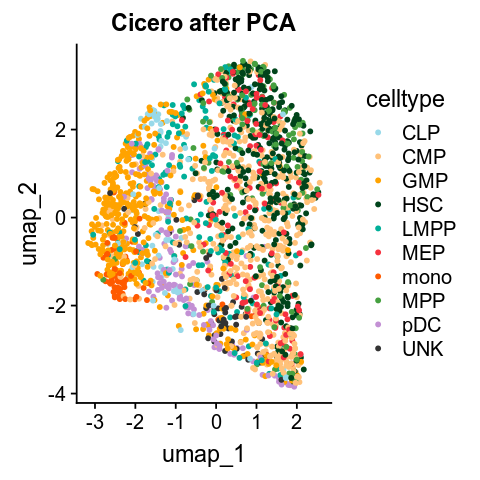

In [34]:
p_Cicero2 <- plot_umap(df_umap_Cicero2,labels = labels,colormap = colormap,title='Cicero after PCA')
p_Cicero2

### SnapATAC (it doesn't rely on peaks)

In [ ]:
# df_umap_SnapATAC <- run_umap(fm_SnapATAC)

In [ ]:
# p_SnapATAC <- plot_umap(df_umap_SnapATAC,labels = labels,colormap = colormap,title='SnapATAC')
# p_SnapATAC

### scABC

In [35]:
df_umap_scABC <- run_umap(fm_scABC)

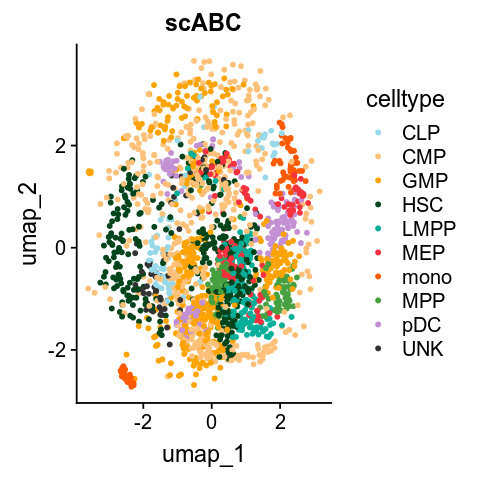

In [36]:
p_scABC <- plot_umap(df_umap_scABC,labels = labels,colormap = colormap,title='scABC')
p_scABC

### SCRAT (it doesn't rely on peaks)

In [ ]:
# df_umap_SCRAT <- run_umap(fm_SCRAT)

In [ ]:
# p_SCRAT <- plot_umap(df_umap_SCRAT,labels = labels,colormap = colormap,title='SCRAT')
# p_SCRAT

In [ ]:
# p_elbow_SCRAT <- elbow_plot(fm_SCRAT,num_pcs = 20, title = 'PCA on SCRAT')
# p_elbow_SCRAT

In [ ]:
# fm_SCRAT2 = run_pca(fm_SCRAT,num_pcs = 10)

In [ ]:
# df_umap_SCRAT2 <- run_umap(fm_SCRAT2)

In [ ]:
# p_SCRAT2 <- plot_umap(df_umap_SCRAT2,labels = labels,colormap = colormap,title='SCRAT after PCA')
# p_SCRAT2

### Scasat

In [37]:
df_umap_Scasat <- run_umap(fm_Scasat)

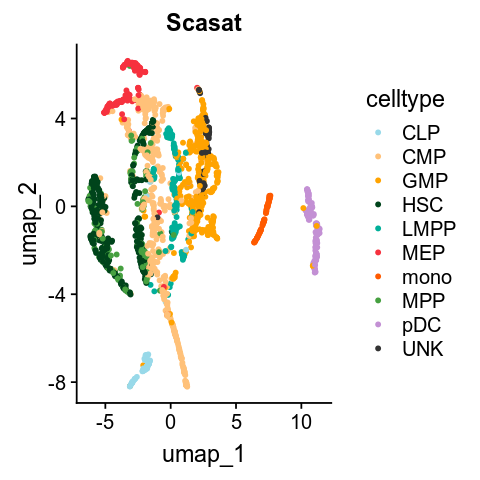

In [38]:
p_Scasat <- plot_umap(df_umap_Scasat,labels = labels,colormap = colormap,title='Scasat')
p_Scasat

### BROCKMAN  (it doesn't rely on peaks)

In [ ]:
# df_umap_BROCKMAN <- run_umap(fm_BROCKMAN)

In [ ]:
# p_BROCKMAN <- plot_umap(df_umap_BROCKMAN,labels = labels,colormap = colormap,title='BROCKMAN')
# p_BROCKMAN

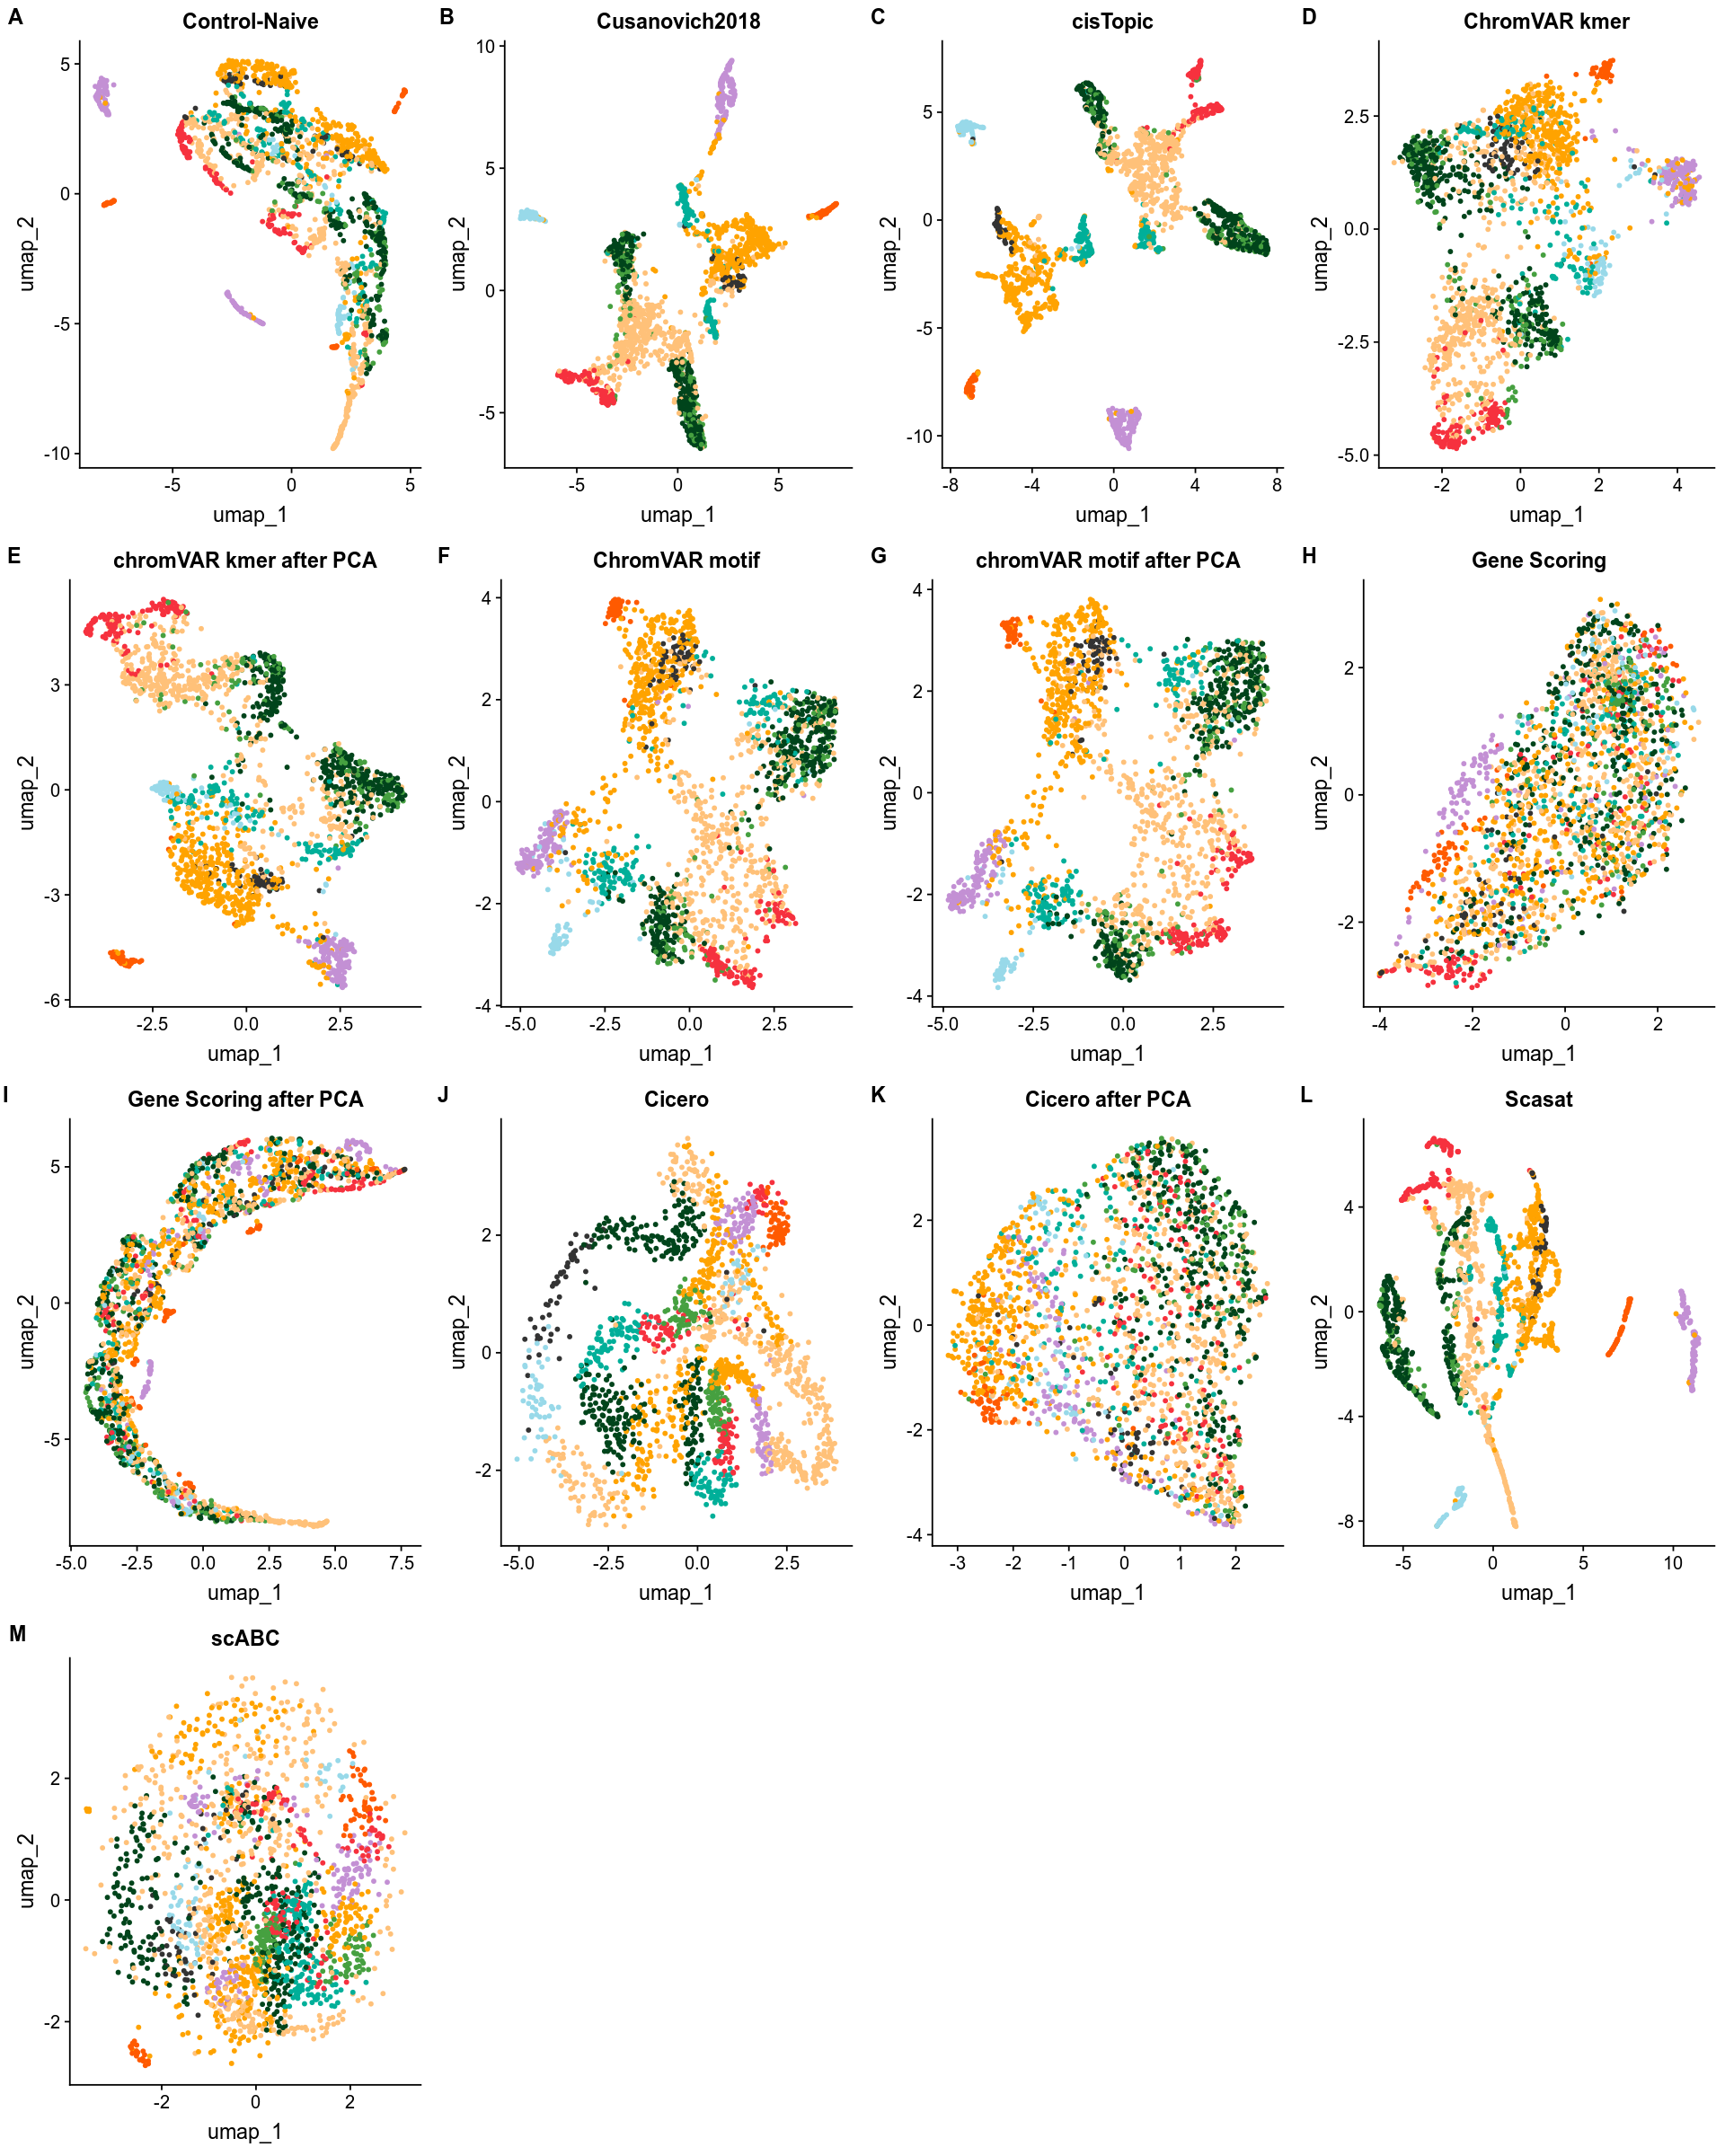

In [40]:
options(repr.plot.width=4*4, repr.plot.height=4*5)
cowplot::plot_grid(p_Control+theme(legend.position = "none"),
#                    p_BROCKMAN+theme(legend.position = "none"),
                   p_Cusanovich2018+theme(legend.position = "none"),p_cisTopic+theme(legend.position = "none"),
                   p_chromVAR_kmers+theme(legend.position = "none"),p_chromVAR_kmers2+theme(legend.position = "none"),
                   p_chromVAR_motifs+theme(legend.position = "none"),p_chromVAR_motifs2+theme(legend.position = "none"),
                   p_GeneScoring+theme(legend.position = "none"),p_GeneScoring2+theme(legend.position = "none"),
                   p_Cicero+theme(legend.position = "none"),p_Cicero2+theme(legend.position = "none"),
#                    p_SnapATAC+theme(legend.position = "none"),
                   p_Scasat+theme(legend.position = "none"),
#                    p_SCRAT+theme(legend.position = "none"),p_SCRAT2+theme(legend.position = "none"),
                   p_scABC+theme(legend.position = "none"),
                   labels = "AUTO",ncol = 4)

#### Save feature matrices and UMAP coordinates

In [41]:
dataset = 'buenrostro2018bulkpeaks'

In [43]:
saveRDS(df_umap_Control,paste0(path_umap,'df_umap_Control.rds'))
# saveRDS(df_umap_BROCKMAN,paste0(path_umap,'df_umap_BROCKMAN.rds'))
saveRDS(df_umap_Cusanovich2018,paste0(path_umap,'df_umap_Cusanovich2018.rds'))
saveRDS(df_umap_cisTopic,paste0(path_umap,'df_umap_cisTopic.rds'))
saveRDS(df_umap_chromVAR_kmers,paste0(path_umap,'df_umap_chromVAR_kmers.rds'))
saveRDS(df_umap_chromVAR_kmers2,paste0(path_umap,'df_umap_chromVAR_kmers2.rds'))
saveRDS(df_umap_chromVAR_motifs,paste0(path_umap,'df_umap_chromVAR_motifs.rds'))
saveRDS(df_umap_chromVAR_motifs2,paste0(path_umap,'df_umap_chromVAR_motifs2.rds'))
saveRDS(df_umap_GeneScoring,paste0(path_umap,'df_umap_GeneScoring.rds'))
saveRDS(df_umap_GeneScoring2,paste0(path_umap,'df_umap_GeneScoring2.rds'))
saveRDS(df_umap_Cicero,paste0(path_umap,'df_umap_Cicero.rds'))
saveRDS(df_umap_Cicero2,paste0(path_umap,'df_umap_Cicero2.rds'))
# saveRDS(df_umap_SnapATAC,paste0(path_umap,'df_umap_SnapATAC.rds'))
saveRDS(df_umap_Scasat,paste0(path_umap,'df_umap_Scasat.rds'))
saveRDS(df_umap_scABC,paste0(path_umap,'df_umap_scABC.rds'))
# saveRDS(df_umap_SCRAT,paste0(path_umap,'df_umap_SCRAT.rds'))
# saveRDS(df_umap_SCRAT2,paste0(path_umap,'df_umap_SCRAT2.rds'))

In [46]:
saveRDS(fm_chromVAR_kmers2, file = paste0(path_fm,'FM_chromVAR_',dataset,'_kmers_pca.rds'))
saveRDS(fm_chromVAR_motifs2, file = paste0(path_fm,'FM_chromVAR_',dataset,'_motifs_pca.rds'))
saveRDS(fm_GeneScoring2, file = paste0(path_fm,'FM_GeneScoring_',dataset,'_pca.rds'))
saveRDS(fm_Cicero2, file = paste0(path_fm,'FM_Cicero_',dataset,'_pca.rds'))
# saveRDS(fm_SCRAT2, file = paste0(path_fm,'FM_SCRAT_',dataset,'_pca.rds'))

In [47]:
save.image(file = 'run_umap_buenrostro2018bulkpeaks.RData')